# Financial Exploratory Analysis

This exploratory analysis seeks to better understand issues and relationships surrounding financial data. The data sources are from two categories: public domain financial data and textual data. 

## Get S&P500 stocker tickers and related data

In [1]:
%matplotlib inline
from financedataanalysis.data import *

## Exploratory analysis for relationships in the data

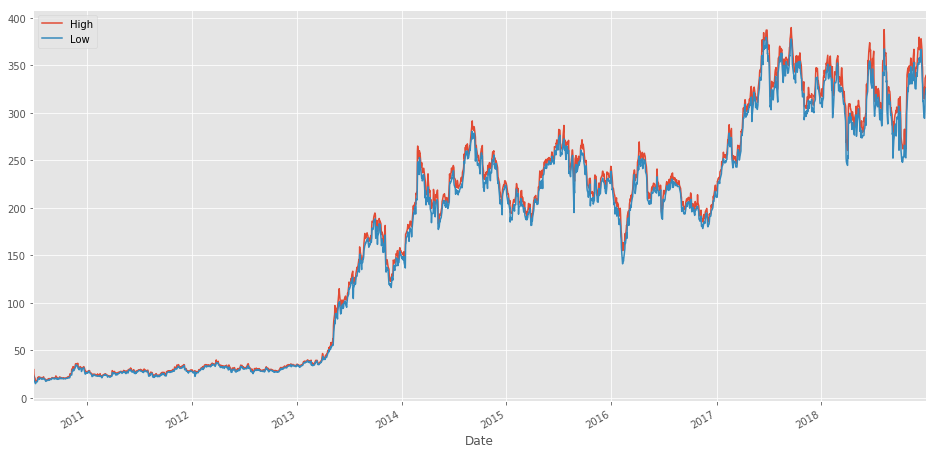

In [2]:
# Plot various stats from selected ticker data
#
start = dt.datetime(2000,1,1)
end = dt.datetime(2018,12,31)
df = web.DataReader('TSLA', 'yahoo', start, end)

#df.head()
df.to_csv('tsla.csv')
df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)

plt.rcParams['figure.figsize'] = [16, 8]

#df['Adj Close'].plot()
df[['High','Low']].plot()

In [3]:
# Create 100 day rolling average data as a column in dataset
#
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail()  # examine the new '100ma' column data

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015,318.4833
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996,318.2488
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005,317.9284
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995,317.8472
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988,317.3795


<BarContainer object of 2142 artists>

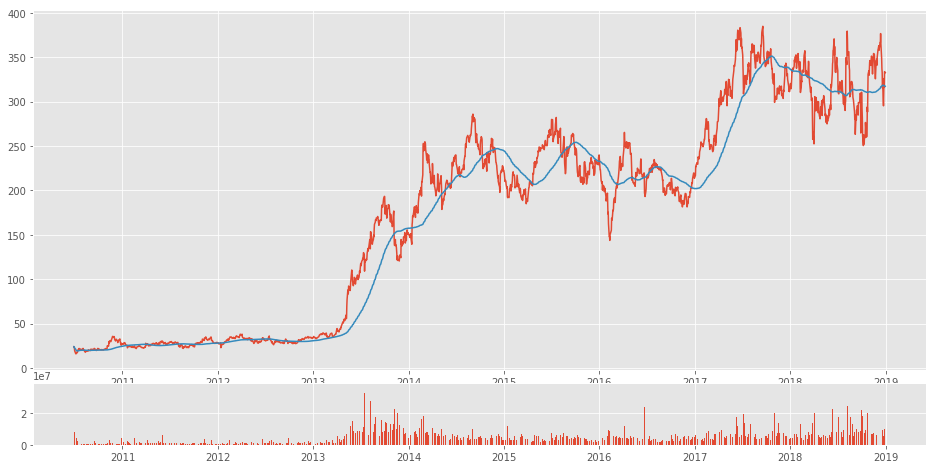

In [4]:
# Configure plot
plt.rcParams['figure.figsize'] = [16, 8]

ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

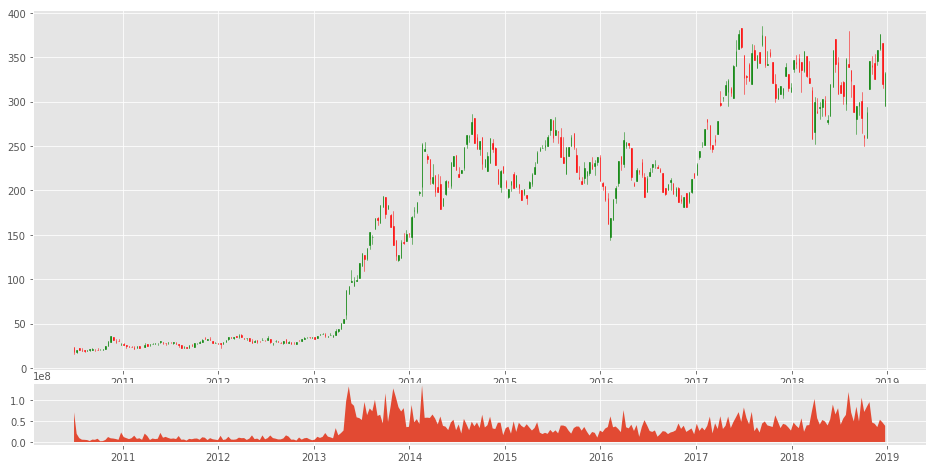

In [5]:
# Candlestick plot vs Volume

df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc = df_ohlc.reset_index()
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

plt.rcParams['figure.figsize'] = [16, 8]
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()

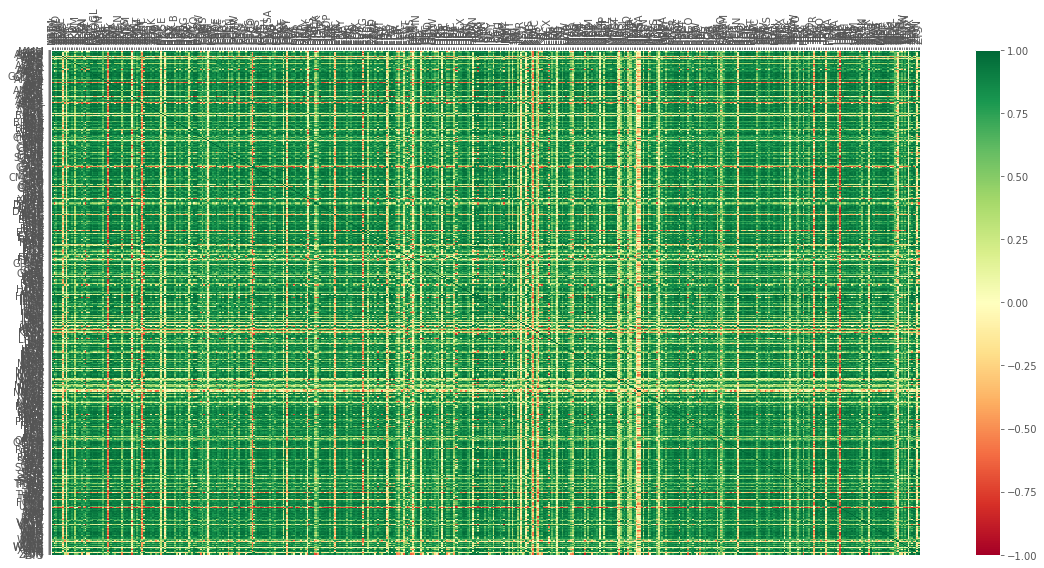

In [6]:
# Visualize the correlation of ticker 'Adj Close' data - the plot is massive
visualize_data_correlation()

In [7]:
# Preprocessing for ML modeling
from collections import Counter
from sklearn import svm, model_selection as cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

def process_data_for_labels(ticker):
    """blah"""
    predict_days = 7  # predict future price in days
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, predict_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df

In [8]:
#process_data_for_labels('BAC')

In [9]:
def buy_sell_hold(*args):
    """blah"""
    cols = [c for c in args]
    requirement = 0.02  # 2% change fires buy or sell trigger
    for col in cols:
        if col > requirement:
            return 1  # buy
        if col < requirement:
            return -1  # sell
    return 0

In [10]:
# 
def extract_bsh_featuresets(ticker):
    """blah"""
    tickers,df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]
                                               ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df - df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()  # normalize the values
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    # X are featuresets, y are labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [11]:
#extract_bsh_featuresets('AAPL')

In [12]:
# ML Classifier
def do_ml(ticker):
    """blah"""
    X, y, df = extract_bsh_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = neighbors.KNeighborsClassifier()
    
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    
    print('Predicted spread: ', Counter(predictions))
    print('Accuracy: ', confidence)
    
    return confidence
    

In [13]:
do_ml('BAC')

Data spread:  Counter({'-1': 4165, '1': 614})
Predicted spread:  Counter({-1: 1170, 1: 25})
Accuracy:  0.8619246861924686


0.8619246861924686